### DD Run
 - Circuit Used - GHZ Echo circuit
 - Qubits Tested - [7, 12, 17, 22, 25, 30, 35]
 - Test-Cases - No-DD Vs DD_XX Vs Cust_DD
 - Circuit Transpilation - Default transpiled with Optimization level = 3
 - Cust_DD conditions -  if (
                total_time_needed > T_idle_dt
                or tot_gate_err >= 2 * decoher_err_prob
                or n_pi_candidate > 2
            )

In [1]:
import sys
import os

# Add project root (one level up from 'notebooks')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    Batch
)
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit.primitives import StatevectorEstimator as SVEstimator
from adaptive_error_mitigation.analytics import (
    extract_basic_features,
    extract_backend_metrics,
    calculate_derived_noise_metrics,
    analyze_qubit_idling,
)
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling, ASAPScheduleAnalysis
from qiskit.circuit.library import XGate
from qiskit.providers.backend import BackendV2 as Backend
from dd_insert_cust import ExecutionConfig, DynamicalDecoupler
from qiskit.visualization.timeline import draw, IQXStandard
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def prepare_echo_ghz_with_xs(n_qubits: int):
    ## Prepares echo circuit with for ghz circuit. Xs at the end to make the expectation value 1.
    # Create GHZ state
    ghz = QuantumCircuit(n_qubits)
    ghz.h(0)
    for i in range(n_qubits - 1):
        ghz.cx(i, i + 1)

    # Loschmidt echo circuit: GHZ → barrier → GHZ† → measurement
    circuit = QuantumCircuit(n_qubits)
    circuit.compose(ghz, inplace=True)
    circuit.barrier()
    circuit.compose(ghz.inverse(), inplace=True)
    circuit.x(range(n_qubits))

    return circuit


def naked_estimator(mode):
    ## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": False, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": False,
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator

def pm_for_backend(bknd, opt_level=3, seed=42069):
    ## Returns a PassManager from generate_preset_pass_manager for given opt_level and backend(bknd)
    pm = generate_preset_pass_manager(
        optimization_level=opt_level,
        backend=bknd,
        seed_transpiler=seed,
    )
    return pm


def create_isa_observables(isa_circuit_dict, pauli_char="Z"):
    ## Returns a dict of ISA observables with layouts applied, matching the input isa_circuit_dict keys.
    isa_observables = {}

    for key, isa_qc in isa_circuit_dict.items():
        # 1. Parse qubit count from key
        num_qubits = int(key)

        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp(pauli_char * num_qubits)

        # 3. Apply the layout from the transpiled circuit
        # This maps the observable to the physical qubits on the backend
        isa_obs = observable.apply_layout(isa_qc.layout)

        isa_observables[key] = isa_obs

    return isa_observables

def prepare_dd_pm(backend: Backend, scheduling_method="alap", seq="XX"):
    ## Returns a PassManager for DD with customizable DD sequence and scheduelling method.

    # Default Sequence
    sequenece = [XGate(), XGate()]

    if seq.lower() == "xpxm":
        sequenece = [XGate(), XGate().inverse()]

    target = backend.target
    ## Prepare a preset passmanager for backend optimization_level=3
    pm = pm_for_backend(bknd=backend, opt_level=3, seed=42069)

    if scheduling_method == "alap":
        pm.scheduling.append(ALAPScheduleAnalysis(target=target))
        pm.scheduling.append(
            PadDynamicalDecoupling(target=target, dd_sequence=sequenece)
        )

    elif scheduling_method == "asap":
        pm.scheduling.append(ASAPScheduleAnalysis(target=target))
        pm.scheduling.append(
            PadDynamicalDecoupling(target=target, dd_sequence=sequenece)
        )

    return pm


def transpile_for_dd(circuit, dd_pm):
    isa_dd_circuit = dd_pm.run(circuit)
    return isa_dd_circuit


# Helper function for circuit density
def get_density(qc):
    m = extract_basic_features(qc)
    # Avoid division by zero
    if m["qubits_used"] * m["depth"] == 0:
        return 0
    return (m["num_1q_gates"] + 2 * m["num_2q_gates"]) / (m["qubits_used"] * m["depth"])

def apply_custom_dd(isa_qc, backend, sequence=None):
    """
    Applies custom Dynamical Decoupling logic to an input ISA circuit.
    """
    # 1. Default sequence if none provided
    if sequence is None:
        sequence = [XGate(), XGate()]

    # 3. Configure Execution
    config = ExecutionConfig(
        isa_qc=isa_qc,
        backend=backend,
        dd_sequence_base=sequence,
    )

    # 4. Run Decoupler
    decoupler = DynamicalDecoupler(config)
    cust_dd_circuit = decoupler.run()
    
    # 5. SAFETY: Sanitize the name immediately
    # This prevents the StagedPassManager/AttributeError later
    cust_dd_circuit.name = f"{isa_qc.name}_cust_dd"
    
    return cust_dd_circuit

In [5]:
# Backend
service = QiskitRuntimeService(name="qamp-2025")
bknd_fez = service.backend("ibm_fez")

In [56]:
QUBIT_SET = [7, 12, 17, 22, 25, 30, 35]

In [57]:
## Prepare circuit dict
circuit_dict = {f"{i}": prepare_echo_ghz_with_xs(n_qubits=i) for i in QUBIT_SET}
circuit_dict

{'7': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effd93410>,
 '12': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effa60cd0>,
 '17': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effd90b10>,
 '22': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effa60c90>,
 '25': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effdd24d0>,
 '30': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effd9e950>,
 '35': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17eff22ed10>}

In [58]:
# circuit_dict["15"].draw("mpl", fold=-1)

In [59]:
## Transpiler with optimization_level=3
pm3 = pm_for_backend(bknd_fez)
isa_dict = {f"{i}": pm3.run(circuit_dict[f"{i}"]) for i in QUBIT_SET}

In [60]:
# Circuit density
cd_isa_qc_dict = {f"{q}": get_density(qc) for q, qc in isa_dict.items()}
cd_isa_qc_dict

{'7': 0.2857142857142857,
 '12': 0.1724537037037037,
 '17': 0.12341407151095732,
 '22': 0.09607438016528926,
 '25': 0.0848,
 '30': 0.07092592592592592,
 '35': 0.06095238095238095}

In [61]:
obs_isa_dict = create_isa_observables(isa_dict, pauli_char="Z")

In [62]:
# pm3.scheduling.draw()

In [63]:
## Transpile for DD with XX
dd_xx_pm = prepare_dd_pm(bknd_fez, seq="XX", scheduling_method="alap")
isa_dd_xx_dict = {
    f"{i}": transpile_for_dd(circuit_dict[f"{i}"], dd_xx_pm)
    for i in QUBIT_SET
}

In [64]:
obs_isa_dd_xx_dict = create_isa_observables(isa_dd_xx_dict, pauli_char="Z")

In [65]:
# Create the dictionary for the custom DD circuits
cust_dd_isa_qc_dict = {
    key: apply_custom_dd(qc, bknd_fez) for key, qc in isa_dict.items()
}

In [66]:
# my_style = {
#     "formatter.general.fig_width": 40,
#     "formatter.general.fig_unit_height": 2,
# }

# draw(
#     cust_dd_isa_qc_dict["15"],
#     # isa_dd_xx_dict["15"],
#     target=bknd_fez.target,
#     style=IQXStandard(**my_style),
#     show_delays=False,
#     show_idle=False,
# )

In [67]:
# isa_dd_xx_dict["16"].draw("mpl", fold=-1)

In [68]:
obs_cust_dd_isa_qc_dict = create_isa_observables(cust_dd_isa_qc_dict, pauli_char="Z")

In [69]:
## Simulate on Aer Simulator
aer_estimator = AerEstimator()

aer_pub = [(isa_dict[f"{i}"], obs_isa_dict[f"{i}"]) for i in QUBIT_SET]

for i in QUBIT_SET:
    aer_job = aer_estimator.run(aer_pub)
    aer_result = aer_job.result()

ideal_est = {f"{QUBIT_SET[i]}": aer_result[i].data.evs for i in range(len(QUBIT_SET))}
ideal_est

{'7': array(-1.),
 '12': array(1.),
 '17': array(-1.),
 '22': array(1.),
 '25': array(-1.),
 '30': array(1.),
 '35': array(-1.)}

In [70]:
## PUB for experiment. Each pub has circuit(num_qubits 'q') and contains two circuits [(isa_dict['q']), (isa_dd_dict['q'])]

pub_hardware_dict = {
    f"{i}": [
        (isa_dict[f"{i}"]),
        (isa_dd_xx_dict[f"{i}"]),
        (cust_dd_isa_qc_dict[f"{i}"]),
    ]
    for i in QUBIT_SET
}
pub_hardware_dict

{'7': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17efee09810>,
 '12': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17eff969a50>,
 '17': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17effd99ed0>,
 '22': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17eff969550>,
 '25': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17eff96a390>,
 '30': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17eff968c50>,
 '35': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17efee8e290>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x17efef3d990>]}

### Execution on IBM Quantum Processor

In [71]:
# 1. Flatten the dictionary into a single list of PUBs (Circuit + Observable)
all_pubs = []
result_map = []

obs_dicts_list = [obs_isa_dict, obs_isa_dd_xx_dict, obs_cust_dd_isa_qc_dict]

for qubit_count, circuit_list in pub_hardware_dict.items():

    for i, circ in enumerate(circuit_list):

        # --- SAFETY FIX: Sanitize Names ---
        circ.name = f"{qubit_count}q_idx{i}"

        # --- SELECT OBSERVABLE ---
        target_obs_dict = obs_dicts_list[i]
        current_obs = target_obs_dict[qubit_count]

        # Create the Estimator PUB: (Circuit, Observable)
        # We don't have parameters, so just a tuple of 2 items
        pub = (circ, current_obs)
        all_pubs.append(pub)

        # Store metadata
        result_map.append({"qubits": qubit_count, "index": i})

print(f"Total PUBs per iteration: {len(all_pubs)}")

Total PUBs per iteration: 21


In [72]:
# Store job objects to retrieve results later
batch_jobs = []
NUM_ITRS = 3

# Open the Batch Context
with Batch(backend=bknd_fez) as batch:
    # Initialize Estimator with the batch context
    estimator = naked_estimator(mode=batch)

    # 3. Loop for the iterations
    for i in range(NUM_ITRS):

        # Submit ALL pubs in ONE job
        # Note: all_pubs is already a list of (circuit, observable) tuples
        job = estimator.run(all_pubs)

        batch_jobs.append(job)
        id = job.job_id()
        print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")

print("All jobs submitted. Waiting for results...")

Submitted Job-ID for iteration 1/3...: d59292psmlfc739k5070
Submitted Job-ID for iteration 2/3...: d592933ht8fs73a490sg
Submitted Job-ID for iteration 3/3...: d59293gnsj9s73b67d2g
All jobs submitted. Waiting for results...


In [ ]:
# batch_jobs = []
# jobs = ["d59292psmlfc739k5070", "d592933ht8fs73a490sg", "d59293gnsj9s73b67d2g"]
# for job_id in jobs:
#     job = service.job(job_id=job_id)
#     batch_jobs.append(job)

In [73]:
# 1. Process Results
method_map = {0: "no_dd", 1: "dd_xx", 2: "dd_cust"}
plot_data = []

for iter_idx, job in enumerate(batch_jobs):
    pub_results = job.result()
    current_job_id = job.job_id()

    for i, pub_result in enumerate(pub_results):
        # Retrieve metadata
        meta = result_map[i]
        q_str = str(meta["qubits"])
        idx = meta["index"]

        # --- CHANGE 1: Get Expectation Value (EVS) ---
        ev_exp = float(pub_result.data.evs)

        # --- CHANGE 2: Get Ideal Value ---
        ev_ideal = float(ideal_est[q_str])

        # --- CHANGE 3: Calculate Deviation (Absolute Error) ---
        abs_error = abs(ev_exp - ev_ideal)

        curr_cd = cd_isa_qc_dict[q_str]

        # Format label
        method_name = method_map[idx]
        label = f"{q_str}: {method_name}"

        plot_data.append(
            {
                "Label": label,
                "Iteration": iter_idx + 1,
                "Qubits": int(q_str),
                "Abs_Error": abs_error,
                "Exp_Value": ev_exp,
                "Ideal_Value": ev_ideal,
                "Circuit_Density": curr_cd,
                "Job_ID": current_job_id,
                "Method_Index": idx,
            }
        )

In [74]:
# Create DataFrame & Sort
df = pd.DataFrame(plot_data)
df = df.sort_values(by=["Qubits", "Method_Index"])

df = df.reset_index(drop=True)
df.head(7)

,Label,Iteration,Qubits,Abs_Error,Exp_Value,Ideal_Value,Circuit_Density,Job_ID,Method_Index
0,7: no_dd,1,7,0.350586,-0.649414,-1.0,0.285714,d59292psmlfc739k5070,0
1,7: no_dd,2,7,0.355469,-0.644531,-1.0,0.285714,d592933ht8fs73a490sg,0
2,7: no_dd,3,7,0.357422,-0.642578,-1.0,0.285714,d59293gnsj9s73b67d2g,0
3,7: dd_xx,1,7,0.358887,-0.641113,-1.0,0.285714,d59292psmlfc739k5070,1
4,7: dd_xx,2,7,0.363281,-0.636719,-1.0,0.285714,d592933ht8fs73a490sg,1
5,7: dd_xx,3,7,0.383789,-0.616211,-1.0,0.285714,d59293gnsj9s73b67d2g,1
6,7: dd_cust,1,7,0.373047,-0.626953,-1.0,0.285714,d59292psmlfc739k5070,2


In [75]:
# Saves the file to the same folder as your notebook
df.to_csv("DD_Batch_GHZ_Echo_Cust_Est_18_2.csv", index=False)

In [6]:
df = pd.read_csv("DD_Batch_GHZ_Echo_Cust_Est_18_2.csv")
df_1 = pd.read_csv("DD_Batch_GHZ_Echo_Cust_Est_17.csv")
df_2 = pd.read_csv("DD_Batch_GHZ_Echo_Cust_Est_18.csv")

In [7]:
# 1. Create a list of the dataframes you want to combine
frames = [df, df_1, df_2]

# 2. Concatenate them
# ignore_index=True ensures the index resets to 0, 1, 2... continuously
df = pd.concat(frames, ignore_index=True)

# 3. (Optional but Recommended) Re-sort so the new data sits in the right place
df = df.sort_values(by=["Qubits", "Method_Index"]).reset_index(drop=True)

# Check the result
print(f"New shape: {df.shape}")
df.head()

New shape: (117, 9)


,Label,Iteration,Qubits,Abs_Error,Exp_Value,Ideal_Value,Circuit_Density,Job_ID,Method_Index
0,7: no_dd,1,7,0.350586,-0.649414,-1.0,0.285714,d59292psmlfc739k5070,0
1,7: no_dd,2,7,0.355469,-0.644531,-1.0,0.285714,d592933ht8fs73a490sg,0
2,7: no_dd,3,7,0.357422,-0.642578,-1.0,0.285714,d59293gnsj9s73b67d2g,0
3,7: dd_xx,1,7,0.358887,-0.641113,-1.0,0.285714,d59292psmlfc739k5070,1
4,7: dd_xx,2,7,0.363281,-0.636719,-1.0,0.285714,d592933ht8fs73a490sg,1


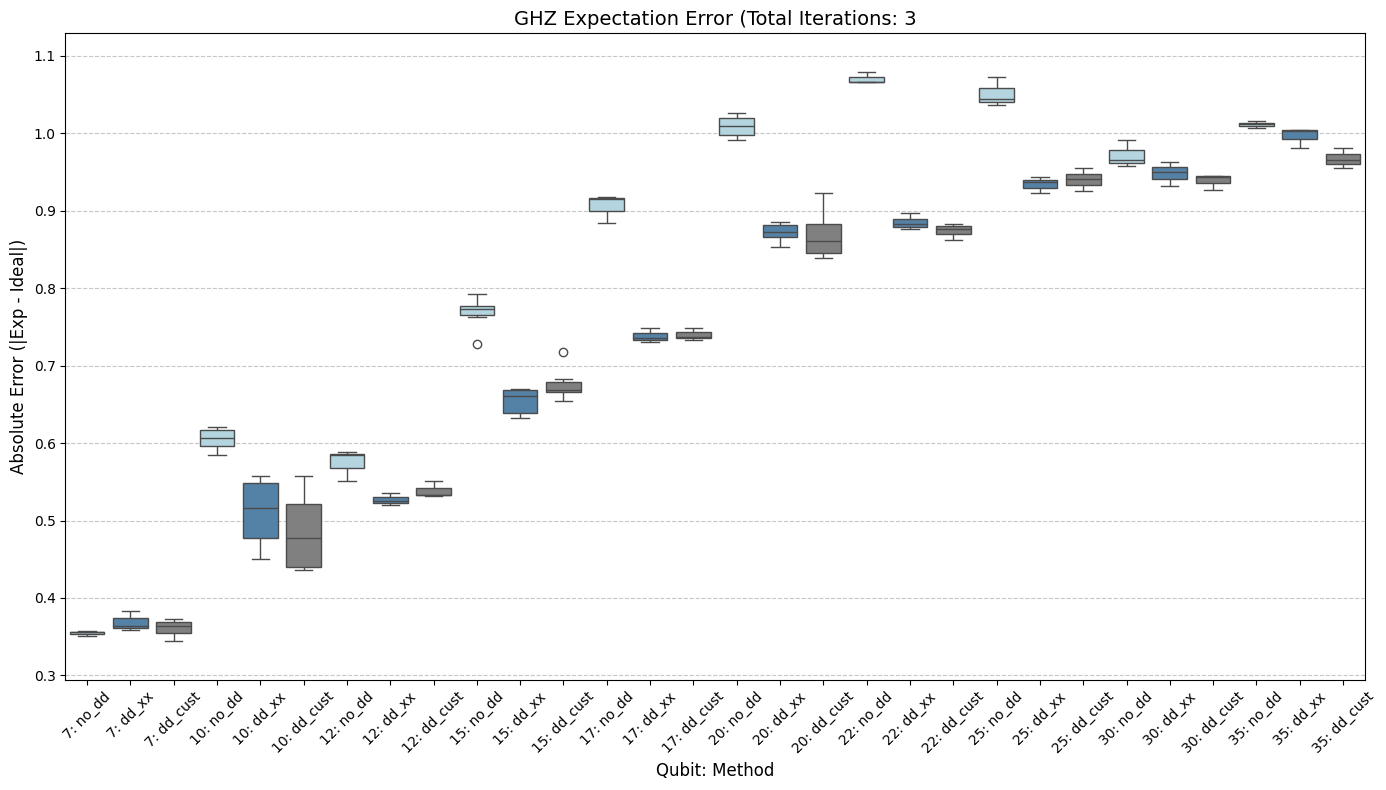

In [9]:
plt.figure(figsize=(14, 8))

# Define colors (Light Blue, Steel Blue, Grey)
color_map = {"no_dd": "#ADD8E6", "dd_xx": "#4682B4", "dd_cust": "#808080"}
unique_labels = df["Label"].unique()
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error", # Plotting Error
    hue="Label",
    palette=palette_list,
    dodge=False,
    legend=False
)

plt.title(f"GHZ Expectation Error (Total Iterations: 3", fontsize=14)
plt.xlabel("Qubit: Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# Calculate minimum fidelity from your data and subtract a 0.05 buffer
min_y = df["Abs_Error"].min() - 0.05
max_y = df["Abs_Error"].max() + 0.05
plt.ylim(min_y, max_y)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# 1. Aggregate: Calculate mean Abs_Error for each Qubit & Method
# We also grab the metrics (Density/Decoherence) which are constant per Qubit
agg_df = (
    df.groupby(["Qubits", "Method_Index"])
    .agg({"Abs_Error": "mean", "Circuit_Density": "first"})
    .reset_index()
)

# 2. Pivot to get columns: [Qubits, Error_no_dd, Error_dd_xx, Density, Decoherence]
# Filter only for no_dd (0) and dd_xx (1)
pivot_df = (
    agg_df[agg_df["Method_Index"].isin([0, 1])]
    .pivot(
        index=["Qubits", "Circuit_Density"],
        columns="Method_Index",
        values="Abs_Error",
    )
    .reset_index()
)

# Rename columns for clarity (0 -> no_dd, 1 -> dd_xx)
pivot_df = pivot_df.rename(columns={0: "Error_no_dd", 1: "Error_dd_xx"})

# 3. Calculate Improvement
# Improvement = Error(no_dd) - Error(dd_xx)
# Positive value means dd_xx reduced the error (Better)
pivot_df["Improvement"] = pivot_df["Error_no_dd"] - pivot_df["Error_dd_xx"]

print(pivot_df.head())

Method_Index  Qubits  Circuit_Density  Error_no_dd  Error_dd_xx  Improvement
0                 10         0.205000     0.670247     0.471842     0.198405
1                 15         0.139259     0.779785     0.594076     0.185710
2                 20         0.105417     1.065755     0.851888     0.213867


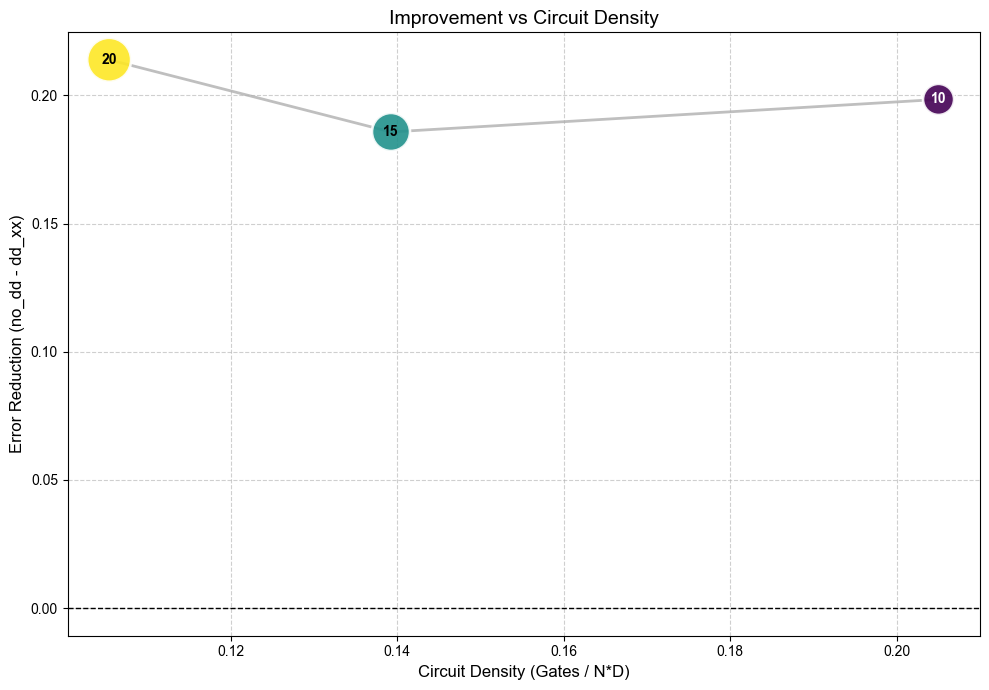

In [27]:
# Setup the figure (Single plot)
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("whitegrid")


# Function to generate smooth curve data (From Template)
def get_smooth_curve(x_data, y_data, k=2, n_points=300):
    # Sort data to prevent spline errors
    sorted_indices = np.argsort(x_data)
    x_sorted = x_data.iloc[sorted_indices]
    y_sorted = y_data.iloc[sorted_indices]

    # Handle duplicates (spline requires unique x)
    x_unique, unique_indices = np.unique(x_sorted, return_index=True)
    y_unique = y_sorted.iloc[unique_indices]

    if len(x_unique) < k + 1:
        return x_unique, y_unique

    x_new = np.linspace(x_unique.min(), x_unique.max(), n_points)
    try:
        spl = make_interp_spline(x_unique, y_unique, k=k)
        y_smooth = spl(x_new)
        return x_new, y_smooth
    except Exception:
        return x_unique, y_unique


# --- PLOT: Improvement vs Circuit Density ---

# 1. Add SMOOTH connecting line
df_sorted = pivot_df.sort_values("Circuit_Density")
x_smooth, y_smooth = get_smooth_curve(
    df_sorted["Circuit_Density"], df_sorted["Improvement"]
)

ax.plot(x_smooth, y_smooth, color="gray", linewidth=2, alpha=0.5, zorder=1)

# 2. Scatter Plot
# Increased sizes to ensure text fits inside the bubbles
sns.scatterplot(
    data=pivot_df,
    x="Circuit_Density",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    size="Qubits",
    sizes=(500, 1000),  # Large bubbles to accommodate text
    ax=ax,
    legend=False,
    zorder=2,
    alpha=0.9,
)

# 3. Add Qubit numbers inside the bubbles
# We iterate through the dataframe to place text at each x,y coordinate
for i in range(pivot_df.shape[0]):
    x_pos = pivot_df["Circuit_Density"].iloc[i]
    y_pos = pivot_df["Improvement"].iloc[i]
    qubit_val = int(pivot_df["Qubits"].iloc[i])

    # Calculate text color based on qubit value (lighter for dark bubbles, darker for light bubbles)
    # Assuming Viridis: Low=Purple(Dark), High=Yellow(Light)
    text_color = "white" if qubit_val < pivot_df["Qubits"].median() else "black"

    ax.text(
        x_pos,
        y_pos,
        str(qubit_val),
        horizontalalignment="center",
        verticalalignment="center",
        size="medium",
        color=text_color,
        weight="bold",
    )

# 4. Reference lines and Labels
ax.set_title("Improvement vs Circuit Density", fontsize=14)
ax.set_xlabel("Circuit Density (Gates / N*D)", fontsize=12)
ax.set_ylabel("Error Reduction (no_dd - dd_xx)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.axhline(0, color="black", linewidth=1, linestyle="--")

plt.tight_layout()
plt.show()